In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.signal import find_peaks, convolve, medfilt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import matplotlib as mpl
from glob import glob
from copy import copy
from natsort import natsorted
from pandas import DataFrame


%matplotlib widget

In [2]:
# freqs, dark_s21 = np.load('./VNAsweep.npy')
freqs, dark_s21 = np.load('.\S21s_20241211_17h7\S21_dark.npy')
M_pxs = 32
N_pxs = 32

995


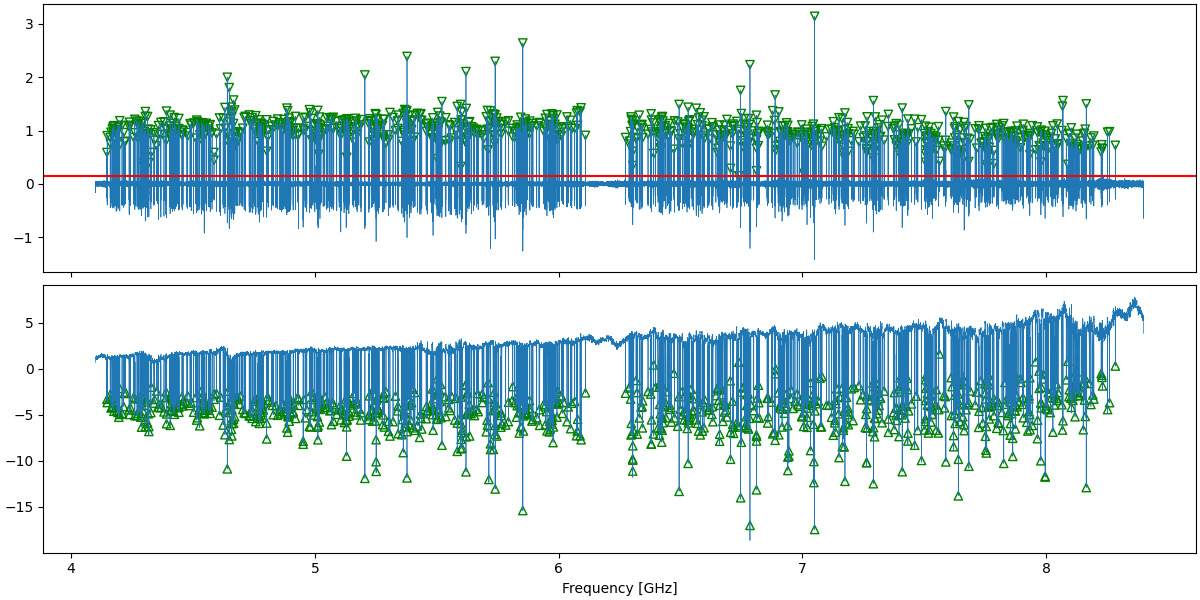

In [3]:
sw = 3 # even number
mph = 0.15
window = np.ones(sw)/sw
smooth_s21 = convolve(dark_s21, window, mode='same')
ds21 = np.diff(smooth_s21, 1)
smooth_ds21 = convolve(ds21, window, mode='same')
d2s21 = np.diff(smooth_ds21, 1)

locs, props = find_peaks(d2s21, height=mph, prominence=mph)
locs[87] += 1
locs[114] += 1
locs[209] += 1
locs[210] -= 1
locs[381] += 1
locs[530] += 1
locs[550] += 1
locs[554] += 1
locs[579] += 1
locs[632] += 1
locs[781] += 1
locs[867] += 1
locs[938] += 1
locs[617] -= 2
locs[939] -= 2
locs[975] += 1
locs[981] += 1
heights = props['peak_heights']

locs += 1
f0s = freqs[locs]
s21_mins = smooth_s21[locs]
fig, ax = plt.subplot_mosaic('a;b', sharex=True, figsize=(12, 6), constrained_layout=True)
ax['a'].plot(freqs[:-2], d2s21, lw=.5)
ax['b'].plot(freqs, smooth_s21, lw=.5)
ax['a'].axhline(mph, c='r')

ax['a'].scatter(freqs[:-2][locs-1], heights, marker='v', c='None', edgecolor='g')
ax['b'].scatter(f0s, s21_mins, marker='^', c='None', edgecolor='g')
ax['b'].set_xlabel('Frequency [GHz]')
print(len(locs))

In [4]:
files = natsorted(glob('./S21s_20241211_17h7/*_*y0.npy'))
print(files)
nr_steps = len(files)
nr_kids = len(locs)
sweeps = np.empty((nr_steps, len(freqs)))
smoothed_sweeps = np.empty((nr_steps, len(freqs)))
s21s = np.empty((nr_steps, nr_kids))
s21s[:] = np.nan
smooth_dark_s21 = convolve(dark_s21, window, mode='same')
s0 = s21_mins
for i, file in enumerate(files):
    f, s21 = np.load(file)
    sweeps[i, :] = s21
    smooth_s21 = convolve(s21, window, mode='same')
    smoothed_sweeps[i, :] = smooth_s21
    s21s[i, :]  = smooth_s21[locs] - s0 

['./S21s_20241211_17h7\\S21_x1y0.npy', './S21s_20241211_17h7\\S21_x2y0.npy', './S21s_20241211_17h7\\S21_x3y0.npy', './S21s_20241211_17h7\\S21_x4y0.npy', './S21s_20241211_17h7\\S21_x5y0.npy', './S21s_20241211_17h7\\S21_x6y0.npy', './S21s_20241211_17h7\\S21_x7y0.npy', './S21s_20241211_17h7\\S21_x8y0.npy', './S21s_20241211_17h7\\S21_x9y0.npy', './S21s_20241211_17h7\\S21_x10y0.npy', './S21s_20241211_17h7\\S21_x11y0.npy', './S21s_20241211_17h7\\S21_x12y0.npy', './S21s_20241211_17h7\\S21_x13y0.npy', './S21s_20241211_17h7\\S21_x14y0.npy', './S21s_20241211_17h7\\S21_x15y0.npy', './S21s_20241211_17h7\\S21_x16y0.npy', './S21s_20241211_17h7\\S21_x17y0.npy', './S21s_20241211_17h7\\S21_x18y0.npy', './S21s_20241211_17h7\\S21_x19y0.npy', './S21s_20241211_17h7\\S21_x20y0.npy', './S21s_20241211_17h7\\S21_x21y0.npy', './S21s_20241211_17h7\\S21_x22y0.npy', './S21s_20241211_17h7\\S21_x23y0.npy', './S21s_20241211_17h7\\S21_x24y0.npy', './S21s_20241211_17h7\\S21_x25y0.npy', './S21s_20241211_17h7\\S21_x26y0.

low SNR:  267
low SNR:  381
low SNR:  526
low SNR:  544
low SNR:  570
low SNR:  617
low SNR:  762
low SNR:  942
total:  987


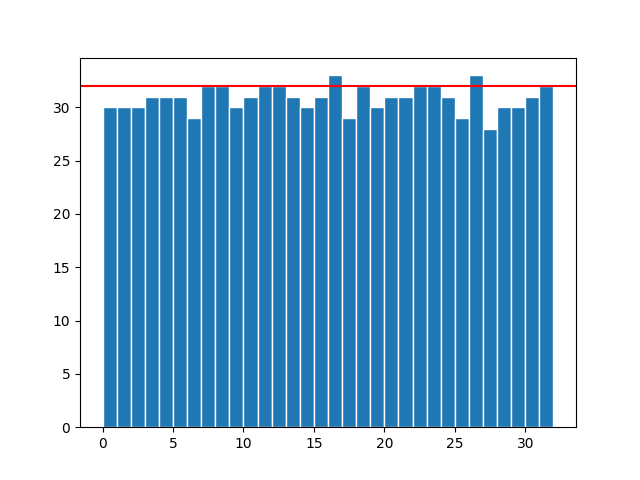

In [5]:
pos = np.empty((nr_kids,8)) # columns: meas idx, meas f0, x, y, design idx, design f0, design finger length, distance to centre
pos[:] = np.nan
pos[:, 0] = np.arange(nr_kids, dtype=int)
pos[:, 1] = f0s
for i in range(nr_kids):
    maximum = np.nanmax(s21s[:, i])
    second_maximum = np.sort(s21s[:, i])[-2]
    minimum = np.nanmin(s21s[:, i])
    mean = (np.sum(s21s[:, i]) - maximum - minimum)/(nr_steps-2)
    maxprominence = maximum - mean
    secprominence =  second_maximum - mean
    if maxprominence < .4:
        print('low SNR: ', int(pos[i, 0]))
    else: 
        pos[i, 3] = np.nanargmax(s21s[:, i])
    # if secprominence > .9:
        # print('overlapping peak? ', int(pos[i, 0]))
fig, ax = plt.subplots()
_ = ax.hist(pos[:, 3], bins=np.arange(nr_steps+1), facecolor='tab:blue', edgecolor='w')
ax.axhline(M_pxs, c='r')
print('total: ', np.sum(~np.isnan(pos[:, 3])))
# pos[267, 3] = ??
pos[381, 3] = 24 
# pos[441, 3] = some crosstalk make at pos 9
pos[526, 3] = 6  
pos[544, 3] = 1  # barely
pos[570, 3] = 19  
# pos[617, 3] = ??
pos[762, 3] = 9  
pos[832,3] = np.nan 
# pos[942, 3] = ??
pos[969, 3] = 3


In [6]:
# # 781 double peak
# pos[781, 3] = 2
# # 724 double peak
# pos[724, 3] = 27
# # 694 triple peak or 696 on 27
# pos[694, 3] = 27
# # 632 triple peak
# pos[632, 3] = 4
# # 632 triple peak
# pos[632, 3] = 23
# # # 564 double peak
# pos[564, 3] = 25
# # 553 double peak
# pos[553, 3] = 15
# # 441 double peak
# pos[441, 3] = 17
# # 416 double peak
# pos[417, 3] = 17
# # 406 double peak
# pos[407, 3] = 25
# # 362 double peak
# pos[362, 3] = 14
# # 322 double peak
# pos[322, 3] = 30
# # 260 triple peak
# pos[260, 3] = 21

In [7]:
add_ids = [724, 694, 632, 564, 553, 441, 417, 407, 362, 322, 260] # should be sorted from high to low
add_rows = [27,27,4,25,15,17,17,25,14,30,21]
for i, id in enumerate(add_ids):
    pos = np.insert(pos, id, pos[id], axis=0)
    pos[id:, 0] += 1
    pos[id, 3] = add_rows[i]
    f0s = np.insert(f0s, id, f0s[id])
    locs = np.insert(locs, id, locs[id])
    s21s = np.insert(s21s, id, s21s[:, id], axis=1)

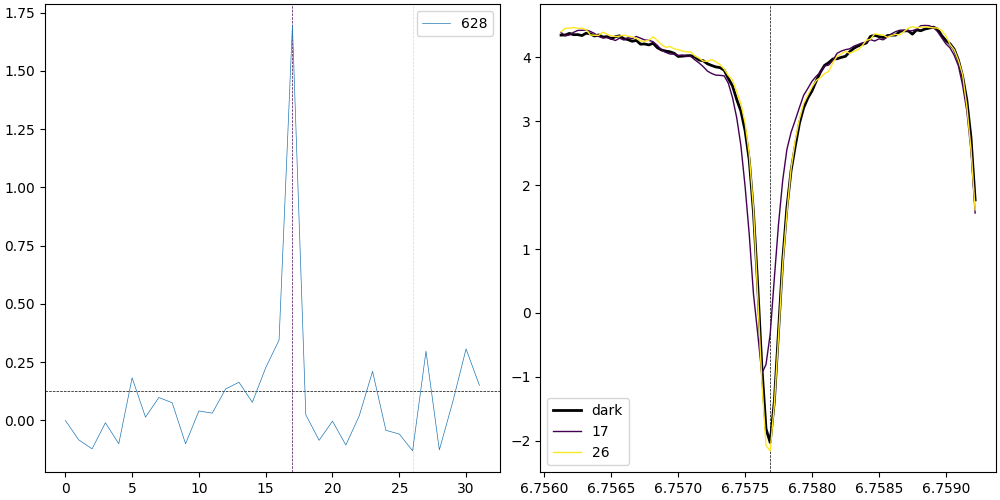

In [8]:
ids = [628]
fig, ax = plt.subplot_mosaic('ba', figsize=(10,5), constrained_layout=True)
start = 0
stop = 20

steps = [17,26]
bw =  50
colors = plt.cm.viridis(np.linspace(0, 1, len(steps)))
for id in ids:
    maximum = np.nanmax(s21s[:, i])
    minimum = np.nanmin(s21s[:, i])
    mean = (np.sum(s21s[:, i]) - maximum - minimum)/(nr_steps-2)
    maxprominence = maximum - mean
    minprominence =  minimum - mean
    res = f0s[id]
    loc = locs[id]
    ax['a'].plot(freqs[loc-bw:loc+bw], smooth_dark_s21[loc-bw:loc+bw], lw=2, c='k', label='dark')
    ax['a'].axvline(res, c='k', ls='--', lw=.5)
    ax['b'].axhline(mean, ls='--', lw=.5, c='k')

    for i, step in enumerate(steps):
        ax['a'].plot(freqs[loc-bw:loc+bw], smoothed_sweeps[step, loc-bw:loc+bw], lw=1, label=str(step), c=colors[i])
        ax['b'].axvline(step, ls='--', lw=.5, c=colors[i])
    ax['b'].plot(s21s[:, id], lw=.5, label=str(id))
ax['b'].legend()
ax['a'].legend()

(26.0, 33.0)

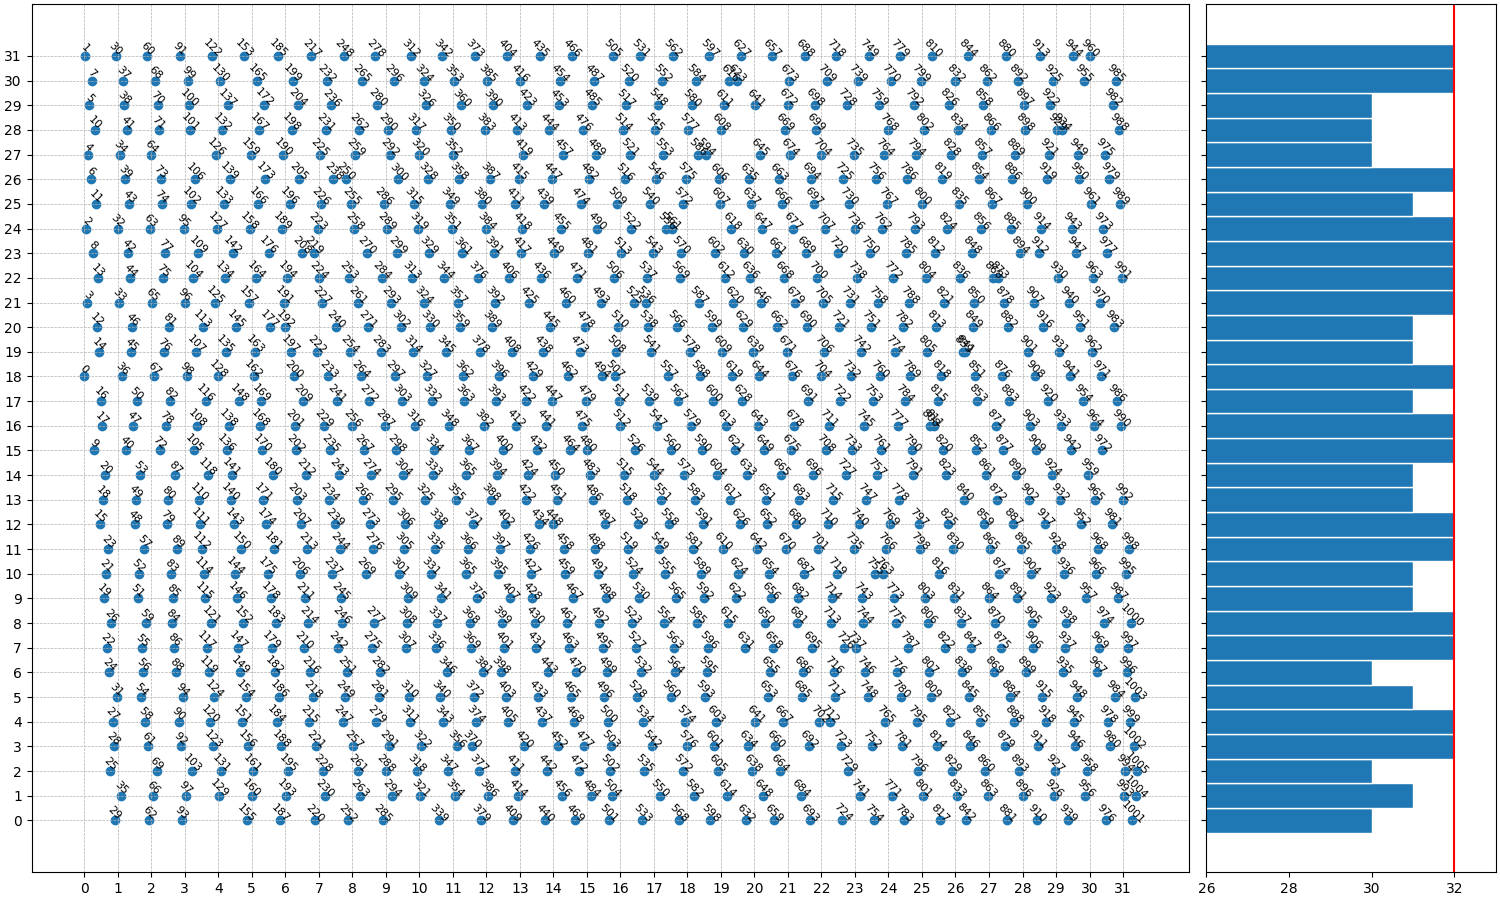

In [9]:
matrix = np.empty((M_pxs, N_pxs))
matrix[:] = np.nan
fig, ax = plt.subplot_mosaic('aaaab', figsize=(15,9), constrained_layout=True, sharey=True)   
ax['a'].scatter(pos[:, 0]/M_pxs, pos[:, 3], c='tab:blue')
for i, txt in enumerate(pos[:, 0]):
    ax['a'].annotate(int(txt), (pos[i, 0]/M_pxs, pos[i, 3]+.3), fontsize=8, ha='center', va='center', rotation=-45)
ax['a'].set_xticks(np.arange(0, M_pxs, 1))
ax['a'].set_yticks(np.arange(0, M_pxs, 1))
ax['a'].grid(True, which='both', linestyle='--', lw=.5)
ax['b'].hist(pos[:, 3], bins=np.arange(nr_steps+1)-.5, facecolor='tab:blue', edgecolor='w', orientation='horizontal')
ax['b'].axvline(M_pxs, c='r')
ax['b'].set_xlim([26,33])
# ax['a'].set_xlim([30,33])


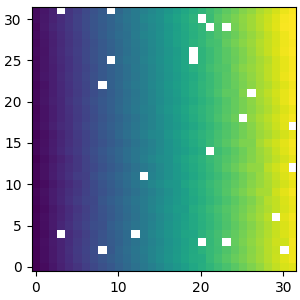

In [10]:
rows = [[] for _ in range(nr_steps)]
for i in pos:
    if not np.isnan(i[3]):
        rows[int(i[3])].append(int(i[0]))
kids_derolled = np.empty((M_pxs, N_pxs))
kids_derolled[:] = np.nan   
for i, row in enumerate(rows):
    kids_derolled[i, :len(row)] = row
nans = [[0,3],[0,9],
        [1,20],
        [2,21],[2,23],
        [5,19],
        [6,9],[6,19],
        [9,8],
        [10,26],
        [13,25],
        [14,31],
        [17,21],
        [20,13],
        [25,29],
        [27,3],[27,12],
        [28,20],[28,23],
        [29,8],[29,30]]
for i, j in nans:
    kids_derolled[i, j+1:] = kids_derolled[i, j:-1]
    kids_derolled[i, j] = np.nan
kids_derolled = np.flip(kids_derolled, axis=0)
fig, ax = plt.subplot_mosaic('a', figsize=(3,3), constrained_layout=True, sharey=True)   
ax['a'].imshow(kids_derolled, cmap='viridis', origin='lower')

[  1.  30.  60.  91. 122. 153. 185. 217. 248. 278. 312. 342. 373. 404.
 435. 466. 505. 531. 562. 597. 627. 657. 688. 718. 749. 779. 810. 844.
 880. 913. 944. 960.]


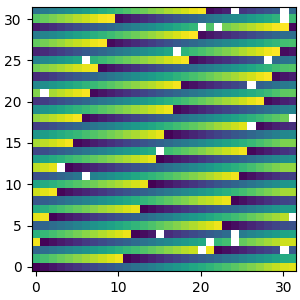

In [11]:
kids = copy(kids_derolled)
print(kids[0])
for i, row in enumerate(kids_derolled):
    kids[i] = np.roll(row, i*11)
# kids[0:2] = np.nan
# kids[-2:] = np.nan
# kids[:, -1] = np.nan
fig, ax = plt.subplot_mosaic('a', figsize=(3,3), constrained_layout=True, sharey=True)   
ax['a'].imshow(kids, cmap='viridis', origin='lower')

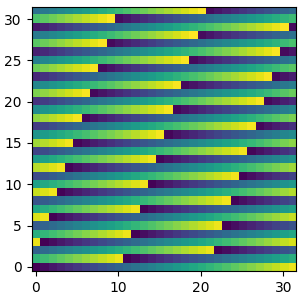

In [12]:
kid_id_board = np.load('kid_id_board_32x32.npy').astype(int)
finger_lengths = np.load('.\LT361_4-8GHz_1024px_fingers.npy')
design_f0s = np.load('LT361_4-8GHz_1024px_F0s.npy')*1e-9
coupler_lengths = np.load('LT361_4-8GHz_1024px_couplers.npy')
# design_f0s_original = np.load('LT361_FAB_F0s.npy')*1e-9
fig, ax = plt.subplot_mosaic('a', figsize=(3,3), constrained_layout=True, sharey=True)   
ax['a'].imshow(kid_id_board, cmap='viridis', origin='lower')

In [13]:
master_array = np.empty((M_pxs*N_pxs, 9)) # columns: row, col, design finger, design couplers, design f0, meas f0, nibble design f0, nibble finger, nibble meas f0
master_array[:] = np.nan    
master_array[:,2] = finger_lengths
master_array[:,3] = coupler_lengths
master_array[:,4] = design_f0s
for i, row in enumerate(kid_id_board):
    for j, idx in enumerate(row):
        master_array[idx, 0] = i
        master_array[idx, 1] = j
        meas_idx = kids[i, j]
        if ~np.isnan(meas_idx):
            meas_f = f0s[int(meas_idx)]
            master_array[idx, 5] = meas_f
master_array[0]
meas = master_array[:, 5]
design = master_array[:, 4]
nanmask = np.isnan(meas)
nanmapmask = np.isnan(kids)

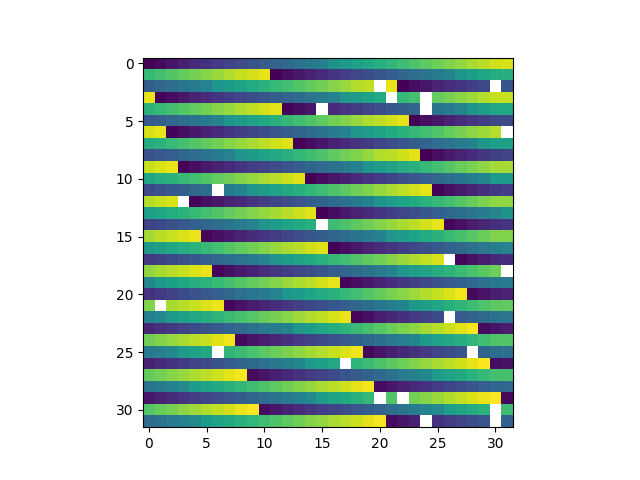

In [84]:
fig, ax = plt.subplots()
ax.imshow(meas[kid_id_board])

line
nan


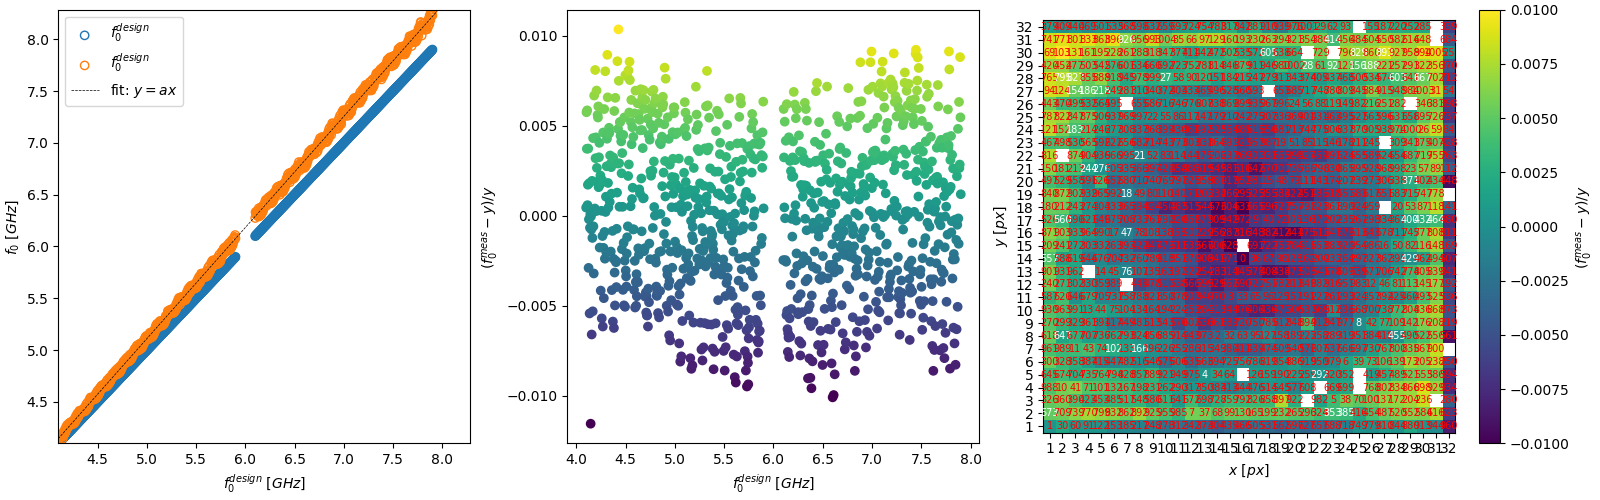

In [14]:
def linear(x, a, b):
    return a*x+b

def secorder(x, a, b, c):
    return a*x**2+b*x

line = linear
popt, pcov = curve_fit(line, design[~nanmask], meas[~nanmask])
design_fit = line(master_array[:, 4], *popt)
df_f_fit = (meas - design_fit) / design_fit
df_f_map = df_f_fit[kid_id_board]
flim = np.array([np.nanmin((design, meas)), np.nanmax((design, meas))])

if line:
    if line == linear:
        eq = 'y=ax'
        save = 'fit_linear'
    elif line == secorder:
        eq = 'y=ax^2+bx'
        save = 'fit_secorder'
    print('line')
    popt, pcov = curve_fit(line, design[~nanmask], meas[~nanmask])
    fit = line(design, *popt)
    xfit = np.linspace(flim[0], flim[1])
    yfit = line(xfit, *popt)
    label = 'y'
else:
    fit = design
    label = 'f_0^{design}'
    save = 'nofit'
size=32

fig, ax = plt.subplot_mosaic('abc', figsize=(16, 5), constrained_layout=True)
ax['a'].scatter(design, design, c='None', edgecolor='tab:blue', label='$\it f_0^{design}$')
ax['a'].scatter(design, meas, c='None', edgecolor='tab:orange', label='$\it f_0^{design}$')
if line:
    ax['a'].plot(xfit, yfit, c='k', label='fit: $%s$' % eq, ls='--', lw=0.5)
ax['a'].set_xlabel('$\it f_0^{design}$ $[GHz]$')
ax['a'].set_ylabel('$\it f_0$ $[GHz]$')
ax['a'].set_xlim(flim)
ax['a'].set_ylim(flim)
ax['a'].legend(loc='upper left')
clim = [-.01, .01]
ax['b'].scatter(design, df_f_fit, c=df_f_fit, vmin=clim[0], vmax=clim[1], label='residual, $f_0-y_2$')
# for i, x in enumerate(design):
#     ax['b'].annotate(i, (x, df_f_corr[i]), fontsize=8, ha='center', va='center')
ax['b'].annotate
ax['b'].set_ylabel('$\it (f_0^{meas}-%s)/%s$' % (label, label))
ax['b'].set_xlabel('$\it f_0^{design}$ $[GHz]$')
im = ax['c'].imshow(df_f_map, cmap='viridis', origin='lower', vmin=clim[0], vmax=clim[1])
for i, x in enumerate(df_f_map):
    for j, y in enumerate(x):
        if ~np.isnan(y):
            old_id = kid_id_board[i, j]
            new_id = kids[i, j]
            if old_id == new_id:
                c = 'w'
            else:
                c = 'r'
            ax['c'].text(j, i, '%d' % new_id, ha='center', va='center', fontsize=7, color=c)
# Major ticks
ax['c'].set_xticks(np.arange(0, size, 1))
ax['c'].set_yticks(np.arange(0, size, 1))
# Labels for major ticks
ax['c'].set_xticklabels(np.arange(1, size+1, 1))
ax['c'].set_yticklabels(np.arange(1, size+1, 1))
# labels
ax['c'].set_xlabel('$\it x$ $[px]$')
ax['c'].set_ylabel('$\it y$ $[px]$')
cbar = fig.colorbar(im, ax=ax['c'])
# cbar.ax.invert_yaxis()
_ = cbar.ax.set_ylabel('$\it (f_0^{meas}-%s)/%s$' % (label, label))
# _ = cbar.ax.set_ylabel('$\it (f_0^{meas}-%s)/%s$' % (label, label))
print(np.std(df_f_fit))
# fig, ax = plt.subplots()
# ax.scatter(pos[:, -1], df_f_corr[np.argsort(meas)])

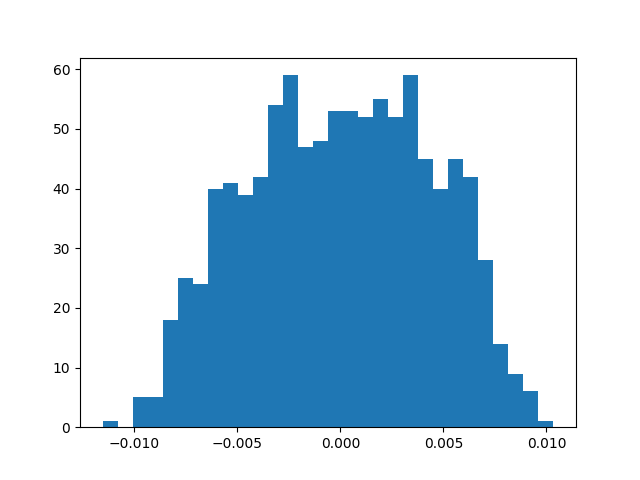

In [15]:
fig, ax = plt.subplots()
_ = ax.hist(df_f_fit, bins=30)

In [16]:
nr_scans = s21s.shape[0]

def map():
    maps = np.zeros((M_pxs, N_pxs, nr_scans))
    for nr in range(nr_scans):
        for i, m in enumerate(kids):
            for j, k in enumerate(m):
                if ~np.isnan(k):
                    k = int(k)
                    s21s[:, k] -= np.amin(s21s[:, k])
                    s21s[:, k] /= np.amax(s21s[:, k])
                    maps[i, j, nr] = s21s[nr, int(k)]
                else:
                    maps[i, j, nr] = np.nan

    return maps

maps = map()

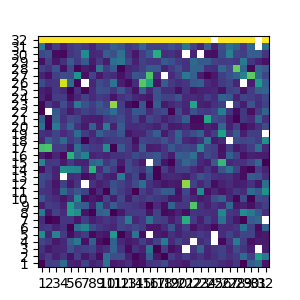

In [17]:
fig, ax = plt.subplots(figsize=(3,3))
ax.imshow(maps[:, :, 0], origin='lower', cmap='viridis')
_ =ax.set_xticks(np.arange(0, size, 1))
_ =ax.set_yticks(np.arange(0, size, 1))
# Labels for major ticks
_ =ax.set_xticklabels(np.arange(1, size+1, 1))
_ =ax.set_yticklabels(np.arange(1, size+1, 1))

In [18]:
# import matplotlib.animation as animation

# fig, ax = plt.subplots(figsize=(8,8))
# cax = ax.imshow(maps[:, :, 0], origin='lower', cmap='viridis')
# for i, x in enumerate(df_fmap):
#     for j, y in enumerate(x):
#             if ~np.isnan(y):
#                 new_id = kids[i, j]
#                 ax.text(j, i, '%d' % new_id, ha='center', va='center', fontsize=7, color='r')
# ax.set_xticks(np.arange(0, size, 1))
# ax.set_yticks(np.arange(0, size, 1))
# # Labels for major ticks
# ax.set_xticklabels(np.arange(1, size+1, 1))
# ax.set_yticklabels(np.arange(1, size+1, 1))

# def update(frame):
#     cax.set_array(maps[:, :, frame])
#     return cax,
# ani = animation.FuncAnimation(fig, update, frames=nr_scans, interval=200, blit=True)
# plt.show()
# ani.save('animation_chip9.gif', writer='Pillow')


In [19]:
def rel_freqs(f0, oct, Q, nr_kids):
    Q_spacing = Q*(2**(oct/nr_kids)-1)
    powers = np.arange(nr_kids)
    f0s = f0 * (1+Q_spacing/Q)**powers
    return f0s

def rel_freqs(f0, fN, nr_kids):
    oct = np.log2(fN/f0)
    gamma = 2**(oct/nr_kids)
    powers = np.arange(nr_kids)
    f0s = f0 * gamma**powers
    return f0s

def lin_freqs(f0, fN, nr_kids):
    return np.linspace(f0, fN, nr_kids, endpoint=True)

def line(x, a, b):
    return a*x+b


In [20]:
sort_idx = np.argsort(meas[~nanmask])
inverse_sort_idx = np.argsort(sort_idx)

0


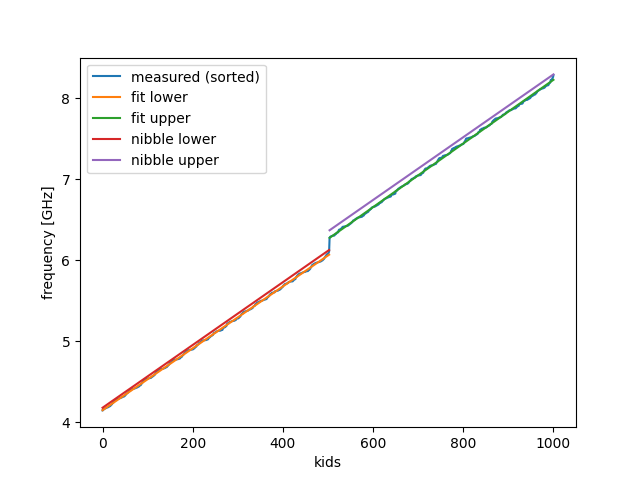

In [60]:
fig, ax = plt.subplots()
sorted_fs = meas[~nanmask][sort_idx]
df = 0.03
nr_kids = len(sorted_fs)
nr_lower = 504
nr_upper = nr_kids - nr_lower
ax.plot(sorted_fs, label='measured (sorted)')
popt, pcov = curve_fit(line, np.arange(nr_lower), sorted_fs[:nr_lower])
ax.plot(line(np.arange(nr_lower), *popt), label='fit lower')  
a_l, b_l = popt[0], popt[1]
popt, pcov = curve_fit(line, np.arange(nr_lower, nr_kids), sorted_fs[nr_lower:])
ax.plot(np.arange(nr_lower,nr_kids), line(np.arange(nr_lower,nr_kids), *popt), label='fit upper')  
a_u, b_u = popt[0], popt[1]
a = (a_l+a_u)/2
nibble_lower = line(np.arange(nr_lower), a, b_l)
smaller = np.sum((nibble_lower - sorted_fs[:nr_lower]) <= 0)
while smaller > 0:
    b_l += df
    nibble_lower = line(np.arange(nr_lower), a, b_l)
    smaller = np.sum((nibble_lower - sorted_fs[:nr_lower]) <= 0)
nibble_upper = line(np.arange(nr_lower, nr_kids), a, b_u)
smaller = np.sum((nibble_upper - sorted_fs[nr_lower]) <= 0)
while smaller > 0:
    b_l += df
    nibble_upper = line(np.arange(nr_lower, nr_kids), a, b_l)
    smaller = np.sum((nibble_upper - sorted_fs[nr_lower:]) <= 0)
print(smaller)
ax.plot(np.arange(nr_lower), nibble_lower, label='nibble lower')
ax.plot(np.arange(nr_lower, nr_kids), nibble_upper, label='nibble upper')
ax.set_ylabel('frequency [GHz]')    
ax.set_xlabel('kids')    
ax.legend()
nibble_freqs = np.hstack((nibble_lower, nibble_upper))[inverse_sort_idx]
master_array[:, 6][~nanmask] = nibble_freqs

minimum trim = -0.53 um


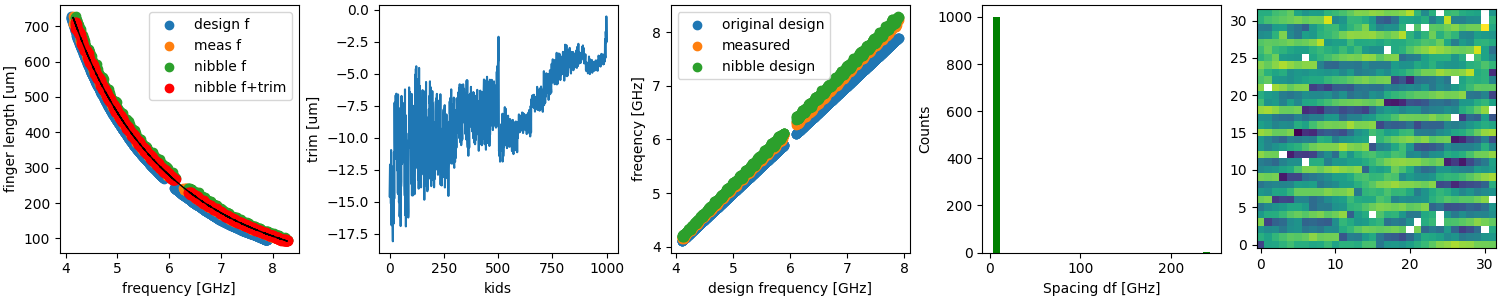

In [89]:
fig, axes = plt.subplot_mosaic('abcde', figsize=(15,3), constrained_layout=True)
ax = axes['a']
fingers = master_array[:, 2]
sorted_fingers = master_array[:, 2][sort_idx]
ax.scatter(design, fingers, label='design f')
ax.scatter(meas, fingers, label='meas f')
ax.scatter(nibble_freqs[inverse_sort_idx], fingers[~nanmask], label='nibble f')
ax.set_ylabel('finger length [um]')
ax.set_xlabel('frequency [GHz]')

def poly(x, a, b, c, d, e, f):
    return a*x**5 + b*x**4 + c*x**3+d*x**2+e*x+f

popt, pcov = curve_fit(poly, meas[~nanmask], fingers[~nanmask])
fit_fingers = poly(meas, *popt)   
ax.plot(meas, fit_fingers, c='k', lw=1)	
new_fingers = poly(nibble_freqs, *popt)
nibble_fingers = new_fingers+(fingers[~nanmask]-fit_fingers[~nanmask])
trims = copy(meas)
trims[~nanmask] = nibble_fingers - fingers[~nanmask]
ax.scatter(nibble_freqs, nibble_fingers, c='r', lw=1, label='nibble f+trim')
ax.legend()

ax = axes['b']
ax.plot(trims[~nanmask])
ax.set_ylabel('trim [um]')
ax.set_xlabel('kids')
print('minimum trim = %.2f um' % np.nanmax(trims))

ax = axes['c']
ax.scatter(design, design, label='original design')
ax.scatter(design, meas, label='measured')
ax.scatter(design[~nanmask], nibble_freqs, label='nibble design')
ax.set_ylabel('freqency [GHz]')
ax.set_xlabel('design frequency [GHz]')
ax.legend()
ax = axes['d']
# bin_edges = np.linspace(0,10,100)
df = (nibble_freqs[sort_idx][1:]-nibble_freqs[sort_idx][:-1])*1e3
ax.hist(df, bins=30, facecolor='g')
ax.set_ylabel('Counts')
ax.set_xlabel('Spacing df [GHz]')
ax = axes['e']
ax.imshow(trims[kid_id_board], origin='lower')

master_array[:, 7][~nanmask] = nibble_fingers

In [91]:
np.save('LT361_chip9_trims.npy', -trims[kid_id_board])


In [ ]:
N_fingers = 13 # number of IDC fingers
nr_fingers_cut = 7
finger_length = 111.# full length of the fingers

In [99]:
nr_fingers = 7
finger_length = 111
max_cut = 104
original_fingers= master_array[:, 2]
nibbled_fingers = master_array[:, 7]
original_cut = nr_fingers*finger_length - original_fingers
nibbled_cut = nr_fingers*finger_length - nibbled_fingers
np.sum((original_cut // max_cut) != (nibbled_cut // max_cut))

73